# SigPy for MRI Tutorial Part 3: Building an L1 Wavelet Reconstruction App

In this notebook, we will create an L1 wavelet regularized reconstruction [App](https://sigpy.readthedocs.io/en/latest/generated/sigpy.app.App.html#sigpy.app.App) from scratch. As you will see, [App](https://sigpy.readthedocs.io/en/latest/generated/sigpy.app.App.html#sigpy.app.App)s can be easily created using tools provided by SigPy.

In particular, SigPy provides three different classes for building iterative reconstruction [App](https://sigpy.readthedocs.io/en/latest/generated/sigpy.app.App.html#sigpy.app.App)'s: 

- [Linop](https://sigpy.readthedocs.io/en/latest/generated/sigpy.linop.Linop.html#sigpy.linop.Linop) for linear operator
- [Prox](https://sigpy.readthedocs.io/en/latest/generated/sigpy.prox.Prox.html#sigpy.prox.Prox) for proximal operator
- [Alg](https://sigpy.readthedocs.io/en/latest/generated/sigpy.alg.Alg.html#sigpy.alg.Alg) for iterative algorithms

This is similar to how BART abstracts iterative reconstructions. By dividing functions into these three classes, many components can be reused, and code can be drastically shortened.

![architecture](https://sigpy.readthedocs.io/en/latest/_images/architecture.pdf)

The L1 wavelet regularization reconstruction solves the following problem:
$$\min_x \frac{1}{2} \| \underbrace{P F S W^H}_{A} x - y \|_2^2 + \lambda \| x \|_1$$
where $P$ is the sampling operator, $F$ is the Fourier transform operator, $S$ is the sensitivity map operator, $W^H$ is the inverse wavelet transform operator, $x$ is the wavelet coefficients and $y$ is the acquired k-space measurements.

The reconstruction image can be generated from $W^H x$.

The general process of creating an L1 wavelet reconstruction App is:

- Create Linops $P, F, S, W$
- Create Prox of the L1 norm
- Create Alg

## Setup

Let us import relevant packages and load the 8-channel Cartesian brain dataset.

In [77]:
%matplotlib notebook
import numpy as np
import sigpy as sp
import sigpy.mri as mr
import sigpy.plot as pl

In [79]:
ksp = np.load('data/cartesian_ksp.npy')
img_shape = ksp.shape[1:]

## Linop

Linear operators are abstracted in the class `Linop`. Given a Linop A, and an appropriately shaped input x, the following are
    both valid operations to compute x -> A(x):

       >>> y = A * x
       >>> y = A(x)

Its adjoint linear operator can be obtained using the `.H` attribute. Linops can be scaled, added, subtracted, stacked and composed.

In the following, we will create the neccessary `Linop`s for L1 wavelet reconstruction. 
To start, we will create a `FFT` Linop, and then apply its adjoint, which is the inverse FFT, to the k-space array `ksp`:

<IPython.core.display.Javascript object>


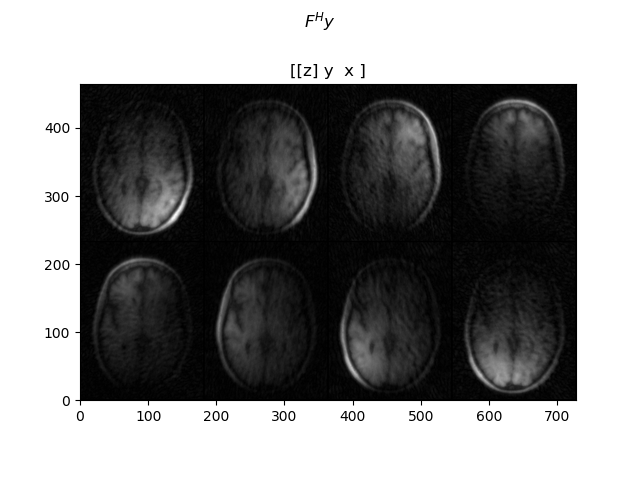

In [82]:
F = sp.linop.FFT(ksp.shape, axes=(-1, -2))

pl.ImagePlot(F.H * ksp, z=0, title=r'$F^H y$')

EspiritCalib: 100%|██████████| 100/100 [00:01<00:00, 73.90it/s]


<IPython.core.display.Javascript object>


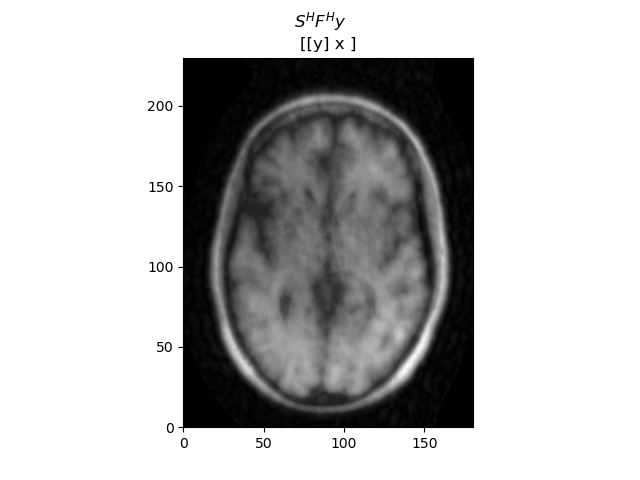

In [83]:
mps = mr.app.EspiritCalib(ksp).run()

S = sp.linop.Multiply(img_shape, mps)

pl.ImagePlot(S.H * F.H * ksp, title=r'$S^H F^H y$')

<IPython.core.display.Javascript object>


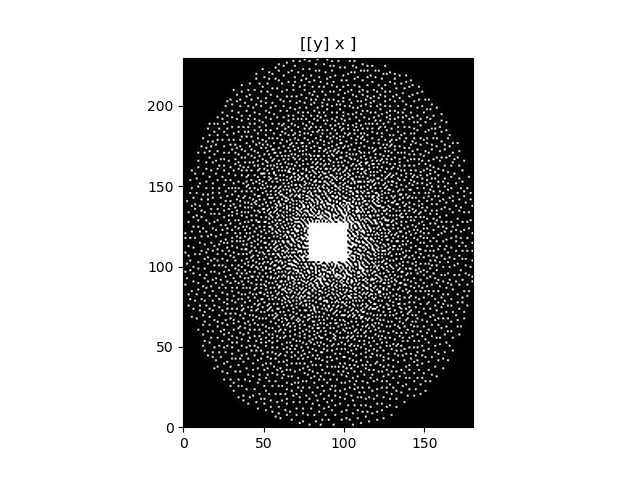

In [9]:
mask = np.sum(abs(ksp), axis=0) > 0
pl.ImagePlot(mask)

P = sp.linop.Multiply(ksp.shape, mask)

<IPython.core.display.Javascript object>


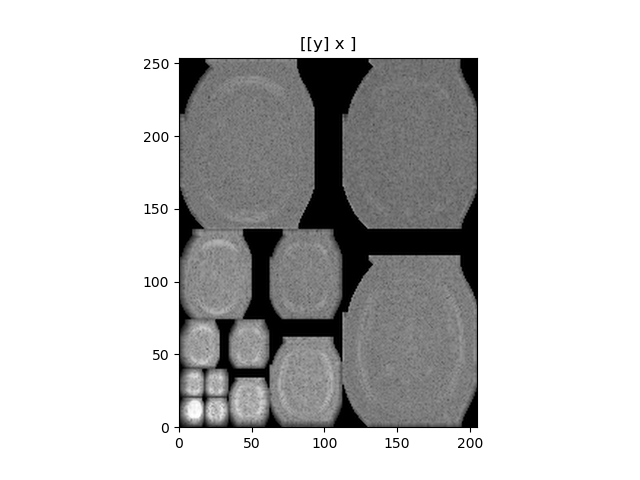

In [18]:
W = sp.linop.Wavelet(img_shape)
wav = W * img_adj
pl.ImagePlot(wav**0.1, title='W')

In [27]:
A = P * F * S * W.H

# Prox

https://sigpy.readthedocs.io/en/latest/core_prox.html

<IPython.core.display.Javascript object>


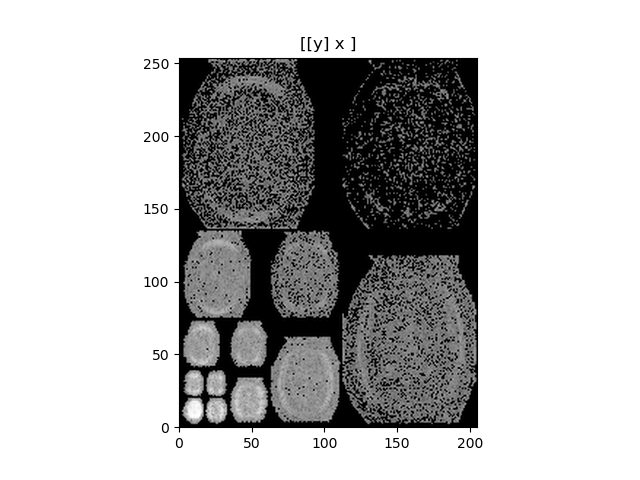

In [26]:
lamda = 0.005
proxg = sp.prox.L1Reg(wav.shape, lamda)
alpha = 1
wav_thresh = proxg(alpha, wav)

pl.ImagePlot(wav_thresh**0.1)

# Alg

https://sigpy.readthedocs.io/en/latest/core_alg.html

In [74]:
max_iter = 30
alpha = 1

def gradf(x):
    return A.H * (A * x - ksp)

wav_hat = np.zeros(wav.shape, np.complex)
alg = sp.alg.GradientMethod(gradf, wav_hat, alpha, proxg=proxg, max_iter=max_iter)

L1WaveletRecon, Iteration=30

<IPython.core.display.Javascript object>


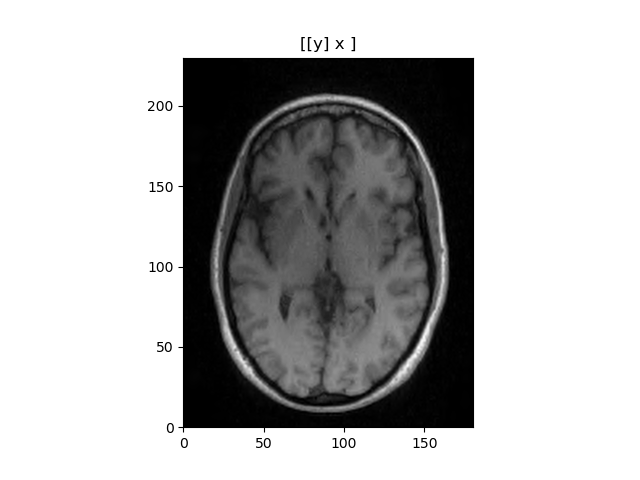

In [75]:
while not alg.done():
    alg.update()

    print('\rL1WaveletRecon, Iteration={}'.format(alg.iter + 1), end='')

pl.ImagePlot(W.H(wav_hat))

# App

In [63]:
class L1WaveletRecon(sp.app.App):
    def __init__(self, ksp, mask, mps, lamda, max_iter):
        img_shape = mps.shape[1:]
        
        S = sp.linop.Multiply(img_shape, mps)
        F = sp.linop.FFT(ksp.shape, axes=(-1, -2))
        P = sp.linop.Multiply(ksp.shape, mask)
        self.W = sp.linop.Wavelet(img_shape)
        A = P * F * S * self.W.H
        
        proxg = sp.prox.L1Reg(A.ishape, lamda)
        
        self.wav = np.zeros(A.ishape, np.complex)
        alpha = 1
        def gradf(x):
            return A.H * (A * x - ksp)

        alg = sp.alg.GradientMethod(gradf, self.wav, alpha, proxg=proxg, 
                                    max_iter=max_iter)
        super().__init__(alg)
        
    def _output(self):
        return self.W.H(self.wav)

L1WaveletRecon: 100%|██████████| 30/30 [00:02<00:00, 15.31it/s]


<IPython.core.display.Javascript object>


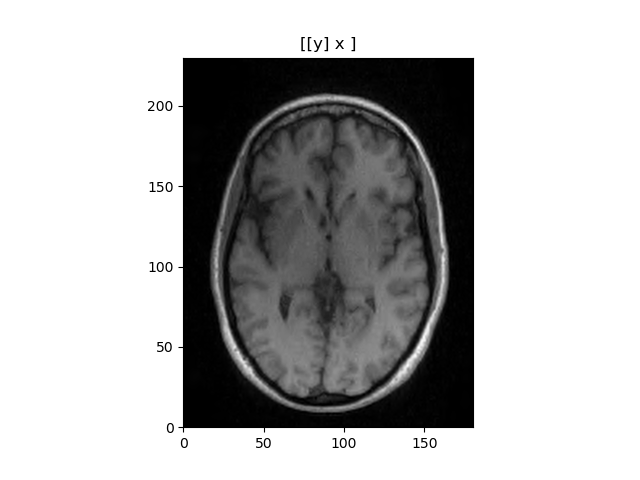

In [76]:
img = L1WaveletRecon(ksp, mask, mps, lamda, max_iter).run()
pl.ImagePlot(img)